In [272]:
import warnings                                                                                                #import libraries
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from time import process_time
from scipy import stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import lightgbm as lgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier as GBoost, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

%matplotlib inline

In [373]:
rootpath = r"~\OneDrive\Desktop\Programming\Datasets\house-price-2"
df = pd.read_csv(rootpath + "/house_price_2.csv")

In [374]:
df.head(2)

,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,...,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,...,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,...,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN


In [375]:
df.drop(['Index'], axis=1, inplace=True)
df_train = df.loc[df['Price (in rupees)'].notna()]
df_test = df.loc[df['Price (in rupees)'].isna()]

In [376]:
print('Train dataset shape: ', df_train.shape)
print('Test dataset shape:  ', df_test.shape)

Train dataset shape:  (169866, 20)
Test dataset shape:   (17665, 20)


In [377]:
df_train = df_train.sample(frac=0.1)
df_train.reset_index(inplace=True)
df_train.drop(['index'], axis=1, inplace=True)

In [378]:
print('New train dataset shape: ', df_train.shape)

New train dataset shape:  (16987, 20)


In [379]:
df = pd.concat([df_train, df_test])

In [380]:
print('Full dataset shape: ', df.shape)

Full dataset shape:  (34652, 20)


In [381]:
df_notna = df.notna().sum()
df_notna

Title                34652
Description          34247
Amount(in rupees)    34652
Price (in rupees)    16987
location             34652
Carpet Area          22561
Status               34575
Floor                33724
Transaction          34575
Furnishing           33584
facing               20157
overlooking          16671
Society              12602
Bathroom             34493
Balcony              26188
Car Parking          13026
Ownership            21461
Super Area           11264
Dimensions               0
Plot Area                0
dtype: int64

In [382]:
na_col = np.unique(df_notna, return_counts=True)
na_col

(array([    0, 11264, 12602, 13026, 16671, 16987, 20157, 21461, 22561,
        26188, 33584, 33724, 34247, 34493, 34575, 34652], dtype=int64),
 array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3], dtype=int64))

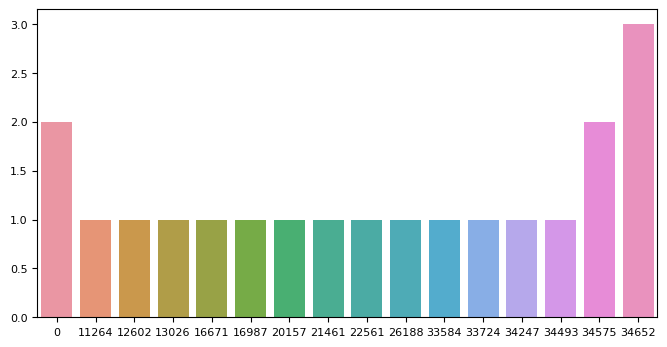

In [383]:
plt.figure(figsize=(8,4))
b = sns.barplot(x=na_col[0], y=na_col[1])
b.tick_params(labelsize=8)

In [384]:
for i in df.columns:
    if (df[i].notna().sum() < 0.5*len(df)) and (i != 'Price (in rupees)'):
        del(df[i]) 

In [385]:
df.shape

(34652, 14)

In [386]:
df_room_count = df['Title'].str.split(pat = ' BHK', expand = True)
df_flat_or_apartment = df['Title'].str.split(pat = ' for sale ', expand = True)
df_flat_or_apartment = df_flat_or_apartment[0].str.split(pat = 'Occupy ', expand = True)
df_flat_or_apartment[1].fillna(df_flat_or_apartment[0], inplace=True)

df_room_count = df_room_count[0]
df_flat_or_apartment = df_flat_or_apartment[1]
    
df = pd.concat([df, df_room_count, df_flat_or_apartment], axis=1)
df.drop(['Title'], axis=1, inplace=True)
df.rename(columns = {0:'Rooms_count', 1:'Flat_or_Apartment'}, inplace=True)

In [387]:
df.replace({'Rooms_count' : {'1': '1 ','2': '2 ','3': '3 ','4': '4 ','5': '5 ','6': '6 ','7': '7 ','8': '8 ','9': '9 ','10': '10 ','> 10': '11 '}}, inplace=True)
df_room_count = df['Rooms_count'].str.split(pat = ' ', expand = True)
df_room_count = df_room_count[0]
df = pd.concat([df, df_room_count], axis=1)
df.drop(['Rooms_count'], axis=1, inplace=True)
df.rename(columns = {0:'Rooms_count'}, inplace=True)
df[['Rooms_count']] = df[['Rooms_count']].apply(pd.to_numeric)

In [388]:
df_amount = df['Amount(in rupees)'].str.split(pat = ' ', expand = True)
df_amount_number = df_amount[0]
df_lac_or_cr = df_amount[1]
df = pd.concat([df, df_amount_number, df_lac_or_cr], axis=1)
df.drop(['Amount(in rupees)'], axis=1, inplace=True)
df.rename(columns = {0:'Amount'}, inplace=True)

In [389]:
df.replace({'Amount' : {'Call': 0}}, inplace=True)
df[['Amount']] = df[['Amount']].apply(pd.to_numeric)
df.replace({1 : {'Cr': 100, 'Lac': 1, 'for': 0}}, inplace=True)
df[[1]] = df[[1]].apply(pd.to_numeric)
df['Amount'] = df['Amount']*df[1]
df.drop([1], axis=1, inplace=True)
df.replace({'Amount' : {0 : np.NaN}}, inplace=True)

In [390]:
df_carpet_area = df['Carpet Area'].str.split(pat = ' ', expand = True)
df_carpet_area = df_carpet_area[0]
df = pd.concat([df, df_carpet_area], axis=1)
df.drop(['Carpet Area'], axis=1, inplace=True)
df.rename(columns = {0:'Carpet_area'}, inplace=True)
df[['Carpet_area']] = df[['Carpet_area']].apply(pd.to_numeric)
df['Carpet_area'].fillna(0, inplace=True)

In [391]:
df['Status'].fillna('Not Ready to Move', inplace=True)

In [392]:
df_floor = df['Floor'].str.split(pat = ' ', expand = True)
df_floors = df['Floor'].str.split(pat = 'of ', expand = True)
df_floor = df_floor[0]
df_floors = df_floors[1]
df = pd.concat([df, df_floor, df_floors], axis=1)
df.drop(['Floor'], axis=1, inplace=True)
df.rename(columns = {0:'Floor', 1:'Floors'}, inplace=True)

In [393]:
df.replace({'Floor' : {'Ground': 0, 'Lower': 0, 'Upper': df['Floors']}}, inplace=True)
df[['Floor', 'Floors']] = df[['Floor', 'Floors']].apply(pd.to_numeric)

In [394]:
df['Transaction'].fillna('Other', inplace=True)
df['Furnishing'].fillna('Unfurnished', inplace=True)

In [395]:
df.replace({'Bathroom' : {'> 10': 11}}, inplace=True)
df[['Bathroom']] = df[['Bathroom']].apply(pd.to_numeric)

In [396]:
df.replace({'Balcony' : {'> 10': 11}}, inplace=True)
df['Balcony'].fillna('0', inplace=True)
df[['Balcony']] = df[['Balcony']].apply(pd.to_numeric)

# Categorical

In [397]:
df.drop(['Description'], axis=1, inplace=True)

In [398]:
df_g = pd.get_dummies(df, drop_first=True)
df_g.reset_index(inplace=True)
df_g.drop(['index'], axis=1, inplace=True)

# Fill in the gaps

In [399]:
df.isna().sum()

Price (in rupees)    17665
location                 0
Status                   0
Transaction              0
Furnishing               0
facing               14495
Bathroom               159
Balcony                  0
Ownership            13191
Flat_or_Apartment        0
Rooms_count            658
Amount                9684
Carpet_area              0
Floor                  928
Floors                 940
dtype: int64

In [400]:
imp = IterativeImputer(max_iter=10, random_state=0)                                                      
imp.fit(df_g.iloc[:,1:].values)
df_g_it = imp.transform(df_g.iloc[:,1:].values)

In [401]:
df_g_it

array([[3.000, 3.000, 3.000, ..., 0.000, 0.000, 1.000],
       [4.000, 2.000, 3.000, ..., 0.000, 0.000, 1.000],
       [3.000, 3.000, 3.000, ..., 0.000, 0.000, 1.000],
       ...,
       [3.000, 2.000, 3.000, ..., 0.000, 0.000, 1.000],
       [4.000, 4.000, 4.000, ..., 0.000, 0.000, 1.000],
       [2.742, 0.000, 3.000, ..., 0.000, 0.000, 1.000]])

In [402]:
df2 = df_g_it

In [403]:
df3 = pd.DataFrame(data=df2, columns=df_g.iloc[:,1:].columns)
df3['Price'] = df_g['Price (in rupees)']

df3.head()

,Bathroom,Balcony,Rooms_count,Amount,Carpet_area,Floor,Floors,location_ahmadnagar,location_ahmedabad,location_allahabad,...,facing_South - East,facing_South -West,facing_West,Ownership_Freehold,Ownership_Leasehold,Ownership_Power Of Attorney,Flat_or_Apartment_ Builder Floor,Flat_or_Apartment_ Studio Apartment,Flat_or_Apartment_Flat,Price
0,3.0,3.0,3.0,225.0,1790.0,11.0,22.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,12103.0
1,4.0,2.0,3.0,60.0,1750.0,9.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2727.0
2,3.0,3.0,3.0,72.0,1300.0,3.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5143.0
3,3.0,0.0,3.0,149.0,0.0,4.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8333.0
4,2.0,1.0,2.0,86.3,1000.0,7.0,32.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7500.0


# Future selection

<AxesSubplot:>

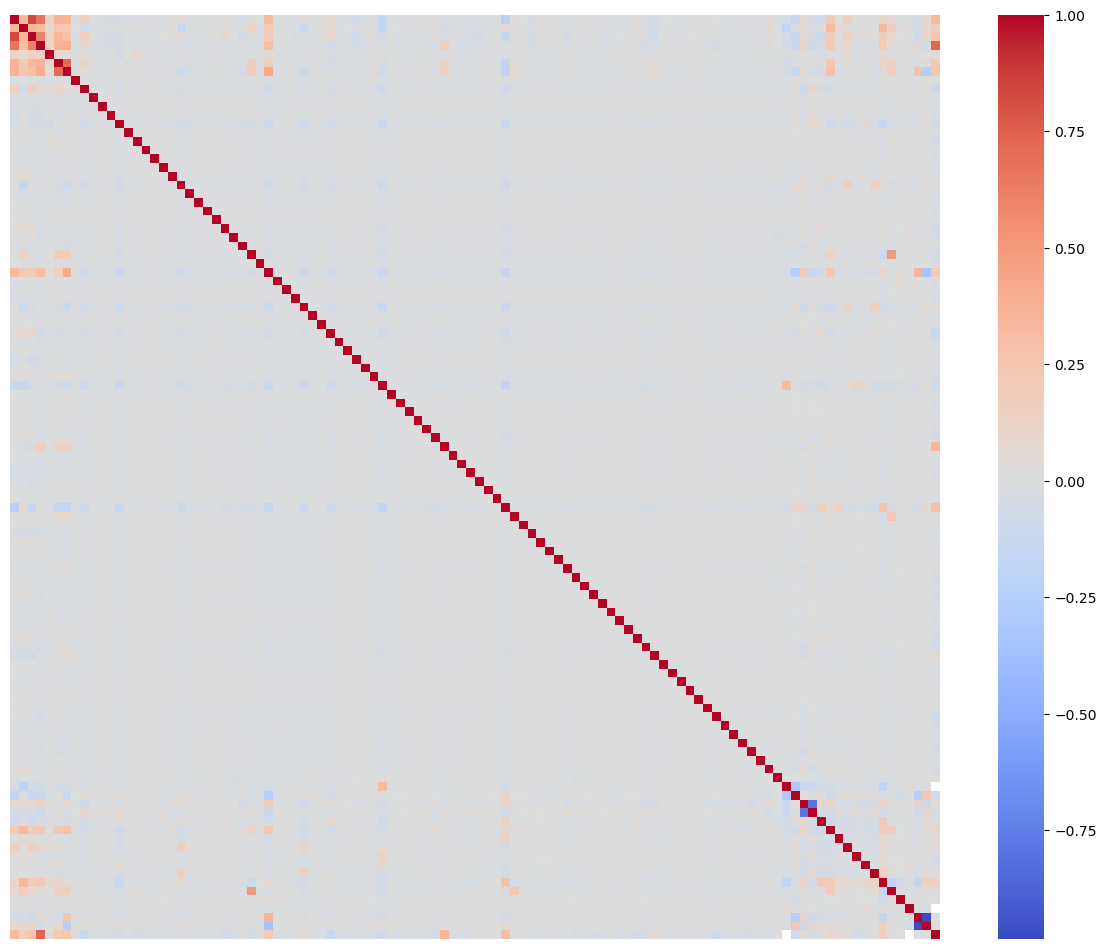

In [404]:
cor = df3.corr()

plt.figure(figsize=(15,12))
sns.heatmap(cor, xticklabels=False, yticklabels=False, cmap='coolwarm')

In [405]:
all_features = list(cor.columns)
f_to_del = []

for i in cor.columns:
    if i == 'Price':
        continue
    for j in cor.index:
        if all_features.index(j) >= all_features.index(i) or j == 'Price':
            continue
        else:
            if abs(cor.loc[i,j]) > 0.8:
                if abs(cor.loc['Price', i]) > abs(cor.loc['Price', j]):
                    f_to_del.append(j)
                else:
                    f_to_del.append(i)

In [406]:
f_to_del = set(f_to_del)
print(len(f_to_del))
f_to_del

2


{'Flat_or_Apartment_ Studio Apartment', 'Rooms_count'}

In [407]:
for i in f_to_del:
    del df3[i]

In [408]:
df3.shape

(34652, 104)

# Splitting into train and test samples

In [413]:
train = df3[:16987]
test = df3[16987:]
test.drop(['Price'], axis=1, inplace=True)

In [415]:
train['Price'].describe()

count     16987.000000
mean       7428.174133
std        4844.843018
min           0.000000
25%        4283.000000
50%        6034.000000
75%        9459.000000
max      100000.000000
Name: Price, dtype: float64

In [416]:
X = train.iloc[:,:-1].values
y = train.iloc[:, -1].values
X = pd.DataFrame(X)
y = pd.DataFrame(y)
y = y + 0.001

In [417]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalizing

In [418]:
scaler = StandardScaler()
list_to_norm = list(X_train.columns[:5].values)
list_binary_features = list(X_train.columns[5:].values)

X_train_to_norm = X_train[list_to_norm]
X_test_to_norm = X_test[list_to_norm]

X_train_to_norm = scaler.fit_transform(X_train_to_norm)
X_test_to_norm = scaler.transform(X_test_to_norm)

X_train_final = np.c_[ X_train_to_norm, np.array(X_train[list_binary_features]) ]
X_test_final  = np.c_[ X_test_to_norm, np.array(X_test[list_binary_features]) ]

y_train_log = np.array(np.log(y_train))
y_test_log = np.array(np.log(y_test))

In [419]:
print(X_train_final.shape,X_test_final.shape, y_train_log.shape,y_test_log.shape)

(13589, 103) (3398, 103) (13589, 1) (3398, 1)


#  Model

In [420]:
reg = LinearRegression().fit(X_train_final, y_train_log)

In [421]:
y_predict = reg.predict(X_test_final)

In [422]:
y_predict_exp = np.exp(y_predict).reshape((y_predict.shape[0],))

In [423]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
y_test_numpy = np.array(y_test)

In [424]:
N1, N2 = 0, 10
print(np.c_[y_predict_exp[N1:N2], y_test_numpy[N1:N2]])

[[3963.531 3553.001]
 [5895.209 6029.001]
 [4394.327 3364.001]
 [4721.626 2815.001]
 [3664.458 7244.001]
 [4044.209 4181.001]
 [4538.736 6390.001]
 [4905.058 5548.001]
 [5796.287 5060.001]
 [4974.373 5271.001]]


In [425]:
print(f'MAE: {mean_absolute_error(y_predict_exp, y_test_numpy)}')

MAE: 1994.9246889470217
